In [51]:
#import important modules
import pymongo as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from pymongo import MongoClient
import json
import pickle
import re
import pprint

In [28]:
with open('editeddata/conversations.json', 'r') as convo_json:
    convos = json.load(convo_json)

In [29]:
client = MongoClient('localhost', 27017)
mydb = client.tweets
col = mydb['_tweets']

In [90]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

In [31]:
air_count = pickle.load(open("save.p", "rb"))

Get the ratio of replied to received tweets for every airline

In [58]:
for name in airlines:
    if len(air_count[name]['ids']) != 0:
        air_count[name]['rep_ratio'] = len(list(col.find({'user.id' : airlines[name]}))) / len(air_count[name]['ids'])
    else:
        air_count[name]['rep_ratio'] = 0

In [77]:
air_count['KLM']['rep_ratio']

0.12852132297505492

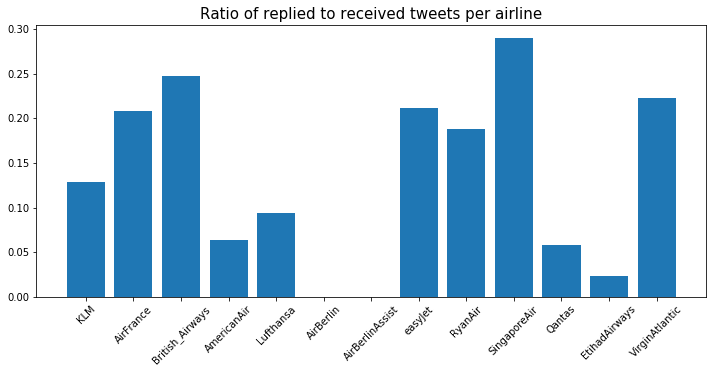

In [104]:
rep_ratios = pd.Series([air_count[name]['rep_ratio'] for name in airlines])
plt.figure(figsize=(12,5))
plt.bar(airlines.keys(), rep_ratios)
plt.xticks(rotation='45')
plt.title('Ratio of replied to received tweets per airline', size=15);

In [112]:
#Average reply/received ratio

sum(list(rep_ratios))/len(rep_ratios)

0.13345621304626304

Number of tweets received from users normalized on the number of followers

In [93]:
for name in airlines:
    if name != 'AirBerlin' and name != 'AirBerlinAssist':
        air_count[name]['followers'] = col.find_one({'user.id': airlines[name]})['user']['followers_count']
        air_count[name]['norm_tweets'] = (air_count[name]['nr']*(1-air_count[name]['rep_ratio']))/air_count[name]['followers']
    else:
        air_count[name]['followers'] = 'unknown'
        air_count[name]['norm_tweets'] = 'unknown'

Note: AirBerlin and AirBerlinAssist are not included since we don't have any tweets from them, hence no information on the number of followers.

In [107]:
for name in airlines:
    print(air_count[name]['norm_tweets'])

0.05690315278679093
0.08737490829053558
0.16499212861505594
0.17534325455220157
0.19193193521205879
unknown
unknown
0.2859667462095734
0.09204724116437656
0.029041847058094955
0.18126486170789705
0.028696688242086328
0.08238347374735909


We get the ratio of tweets customers post to the number of followers a company has.
This is problematic since we are not sure the people who tweeted about an airline are actually their followers.